In [1]:
# This is the notebook for honours project analysis on galaxy cluster XLSSC 122
# This notebook will serve as sort of a journal of what is done on the project
# Proceeds chronologically with updated TODOs:

# First we load in the necessary modules:

# Standard libraries
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import math
import latex

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from matplotlib.patches import Ellipse, Circle

import matplotlib
#matplotlib.use('TkAgg')

# astro specific
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord

from matplotlib import rc

params = {"text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["cmr10"],
          "font.size": 20
         }
plt.rcParams.update(params)
plt.rcParams['axes.formatter.use_mathtext'] = True

import os
os.environ["PATH"]
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin/'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# Set tick parameters using rcParams
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.major.width'] = 0.7
plt.rcParams['xtick.minor.width'] = 0.7
plt.rcParams['ytick.major.width'] = 0.7
plt.rcParams['ytick.minor.width'] = 0.7

plt.rcParams['font.weight'] = 'bold'

from matplotlib.colors import PowerNorm
from matplotlib.colors import LogNorm


In [2]:
# DATA:

# Now need to load in the data files for the fits image as well as the catalogues:

# fits:

fits_path ="/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/IVM_xlssuj0217-0345-f140w_drz_sci.fits"
xlssc_fits = fits.open(fits_path)

# extracted fits:

extract_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/xlssuj0217-0345-f140w_drz_seg_spec_extract.fits"
extract_fits = fits.open(extract_path)

# catalogue files:

# shape of short file: 12 X 1374

# id ra dec (F105) kron ekron 0p8 e0p8 (F140) kron ekron 0p8 e0p8 fwhm (asec) 

cat_sh_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/xlssc122_F105_F140_short.cat"
cat_sh = np.loadtxt(cat_sh_path)
cat_short = np.loadtxt(cat_sh_path).T

# shape of long file: 22 X 1301

# phot-id ra dec (f105) kron ekron 0p8 e0p8 (f140) kron ekron 0p8 e0p8 fwhm (asec) zz zlo zhi chi spec-id mcode snr em-code member1 member2

cat_lo_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/xlssc122_F105_F140_redshifts_short_v4_snr_em_member2_by_hand.cat"
cat_lo = np.loadtxt(cat_lo_path)




In [3]:
cat_short[4], cat_short[8]

unc105 = np.array([cat_short[4][i] if cat_short[4][i]<5 else 0 for i in range(len(cat_short[4]))])
unc140 = np.array([cat_short[8][i] if cat_short[8][i]<5 else 0 for i in range(len(cat_short[8]))])

col_unc = np.sqrt(unc105**2 + unc140**2)



In [4]:
# First order of business is dealing with the fits file. We can start by opening the HDU:

with fits.open(fits_path) as xlssc_fits:
    xlssc_fits.info()

# TODO: Understand this output and fits headers in general

Filename: /Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/IVM_xlssuj0217-0345-f140w_drz_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1197   (4313, 4312)   float32   
  1  HDRTAB        1 BinTableHDU    557   24R x 274C   [9A, 3A, J, D, D, D, D, D, D, D, D, D, D, D, D, J, 9A, 9A, 7A, 18A, D, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, J, J, D, 3A, D, D, D, D, J, J, 8A, 23A, 11A, 18A, 4A, D, D, J, J, D, D, D, D, 23A, D, D, D, D, J, J, D, 3A, 8A, J, D, D, D, 23A, 1A, D, D, D, D, D, D, 12A, 12A, 8A, 23A, D, D, 10A, 10A, D, D, D, 2A, 3A, 3A, 4A, 8A, 7A, D, J, D, 6A, 9A, D, D, D, 4A, 18A, 3A, J, 5A, D, D, D, 8A, D, 3A, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, J, 1A, 4A, D, 3A, 6A, D, D, D, D, D, 23A, D, D, D, D, D, 1A, J, J, J, J, 8A, 23A, J, J, 10A, 7A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 13A, D, 24A, 23A, D, 1A, 1A, D, J, D, D, 1A, 1A, D, D, D, D, D, D, D, D, D, D, D, 4A, D, J, 23A, D, 8A, D, D

In [5]:
xlssc_image = fits.getdata(fits_path, ext=0)

ben = xlssc_image*1.6666666666666E-05


xray_cd = 0.00069444

sci_cd = 1.6666666666666E-05

pixper = xray_cd/sci_cd
pixper

41.66640000000167

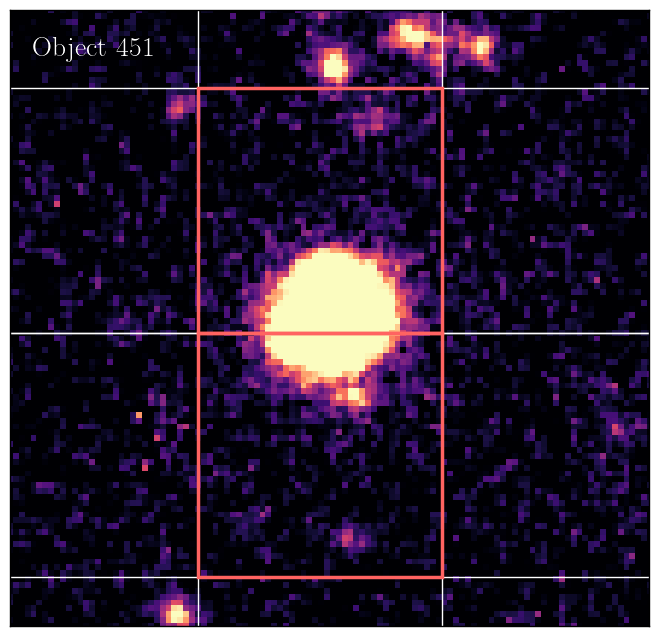

In [6]:
# we can now try to plot the fits file:

# gets image data from the PRIMARY layer of the fits file:

from matplotlib.patches import Rectangle

# plots the image:

width=10
height=8
ff, (ax1) = plt.subplots(1,1)
ff.set_figwidth(width)
ff.set_figheight(height)

im = ax1.imshow(xlssc_image,vmin=0,vmax=0.047,cmap='magma', interpolation='none')


# restricts image to just range of interest:
ax1.set_xlim(2856,2965)
ax1.set_ylim(1860,1965)

ax1.grid(False)
#ax1.invert_yaxis()
ax1.tick_params(axis='x', which='both', bottom=False, top=False, left=False, right=False)

ax1.set_xticks([])
ax1.set_yticks([])

square1 = Rectangle((2888,1910),pixper, pixper, linewidth=2.5, edgecolor='#ff6361', facecolor='none', zorder=10)
ax1.add_patch(square1)

square2 = Rectangle((2888,1910-pixper),pixper, pixper, linewidth=2.5, edgecolor='#ff6361', facecolor='none',zorder=10)
ax1.add_patch(square2)

square3 = Rectangle((2888,1910+pixper),pixper, pixper, linewidth=1, edgecolor='w', facecolor='none')
ax1.add_patch(square3)

square4 = Rectangle((2888-pixper,1910),pixper, pixper, linewidth=1, edgecolor='w', facecolor='none')
ax1.add_patch(square4)

square5 = Rectangle((2888+pixper,1910),pixper, pixper, linewidth=1, edgecolor='w', facecolor='none')
ax1.add_patch(square5)

square6 = Rectangle((2888,1910-2*pixper),pixper, pixper, linewidth=1, edgecolor='w', facecolor='none')
ax1.add_patch(square6)

square7 = Rectangle((2888-pixper,1910-pixper),pixper, pixper, linewidth=1, edgecolor='w', facecolor='none')
ax1.add_patch(square7)

square8 = Rectangle((2888+pixper,1910-pixper),pixper, pixper, linewidth=1, edgecolor='w', facecolor='none')
ax1.add_patch(square8)

ax1.text(2860, 1957, 'Object 451', c='w', weight='bold')

plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/2_manual_flux_example_data", dpi=250)


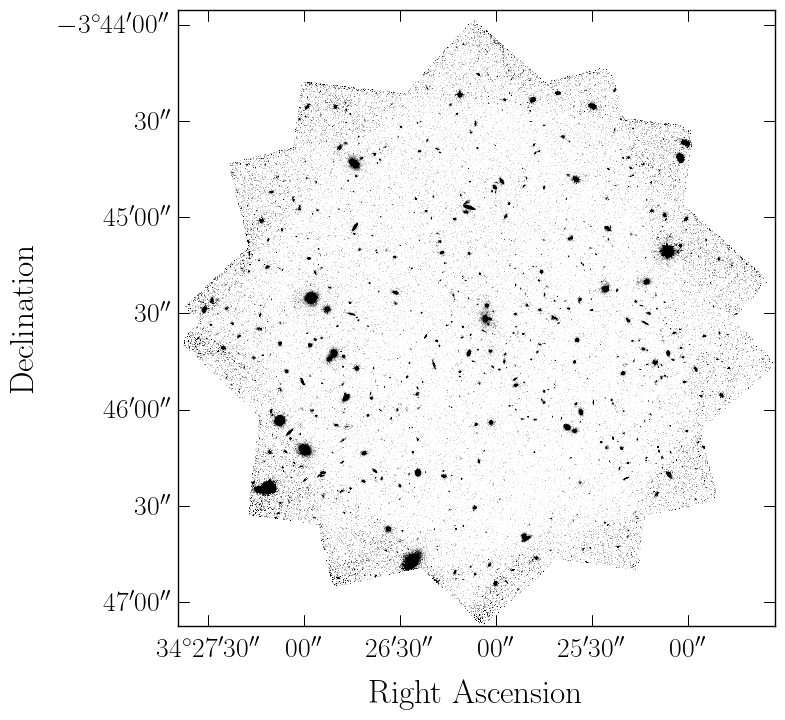

In [7]:
# now we need to convert the axes into RA and DEC: 

# from the header, we have the target center:

RA_TARG =   3.443412500000E+01 #~34 degrees, 26 arcmins, 0 arcseconds
DEC_TARG=  -3.758738888889E+00  # ~ -3 degrees, 45 arcmins, 30 arcseconds

# will try the world coordinate system built into astropy:

xlssc_hdu = fits.open(fits_path)[0]
xlssc_wcs = WCS(xlssc_hdu.header)

ax1=plt.subplot(projection=xlssc_wcs)
ax1.imshow(xlssc_hdu.data,vmin=0.0040,vmax=0.05,cmap='gray_r', interpolation='none')
# restricts image to just range of interest:
ax1.set_xlim(600,3700)
ax1.set_ylim(3800,600)

#ax1.set_title("XLSSC122 Image")
ax1.grid(False)
ax1.invert_yaxis()

# converts the x-axis to degrees and works with the ticks:
lon = ax1.coords[0]
lat = ax1.coords[1]
lon.set_axislabel('Right Ascension')
lat.set_axislabel('Declination')
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(number=6)
lat.set_ticks(number=7)

# increases figure size:
ff = plt.gcf()
ff.set_size_inches(12,8)

# TODO:
# figure out why ticks are not coming up here

plt.show()

In [8]:
# now we need to determine membership of all of the imaged galaxies:

# first, we can use the extended data table for member galaxies:
# TODO: understand the criterion for selection

data_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/extended_data_table.csv"
member_data = np.loadtxt(data_path, dtype='str',delimiter=',', skiprows=1).T

# # cleans up the data:
# member_data[0][0] = '526'
# member_data = member_data.T
# # removes zero column
# member_data = np.delete(member_data, 6, 0)

# Splits into interesting quantities:

mem_ID = np.array(member_data[0], dtype=float); mem_RA = np.array(member_data[1], dtype=float);
mem_DEC = np.array(member_data[2], dtype=float); mem_mag = np.array(member_data[3], dtype=float);
mem_col = np.array(member_data[4], dtype=float); mem_z = np.array(member_data[5], dtype=float);

mem_notes = np.array(member_data[6], dtype=str)
# creates masks for each member group:

gold_mask = np.array([0.0 for i in range(len(mem_ID))])
silver_mask = np.array([0.0 for i in range(len(mem_ID))])
fg_mask = np.array([0.0 for i in range(len(mem_ID))])
e_mask = np.array([0.0 for i in range(len(mem_ID))])

for i in range(len(mem_notes)):
    note = mem_notes[i]
    
    if (note == 'G' or note =='GE'):
        gold_mask[i] = 1
        silver_mask[i] = float("nan")
        fg_mask[i] = float("nan")
        if note == 'GE':
            e_mask[i] = 1
    elif (note == 'SE' or note == 'S'):
        gold_mask[i] = float("nan")
        silver_mask[i] = 1
        fg_mask[i] = float("nan")
        if note == 'SE':
            e_mask[i] = 1
    elif (note == 'F'):
        gold_mask[i] = float("nan")
        silver_mask[i] = float("nan")
        fg_mask[i] = 1
    
# we can now create a list of each member sections for each quantity
# without changing the size of the arrays very easily



In [9]:
# for the next task it will be nice to have the RA and DEC for the 
# gold, silver and foreground galaxies:

gold_RA = mem_RA * gold_mask; gold_DEC = mem_DEC * gold_mask;
silver_RA = mem_RA * silver_mask; silver_DEC = mem_DEC * silver_mask;
fg_RA = mem_RA * fg_mask; fg_DEC = mem_DEC * fg_mask;

In [10]:
gold_RA

array([34.43422, 34.42228, 34.4341 , 34.43245, 34.43503, 34.43563,
       34.44715, 34.43689, 34.43592, 34.43845, 34.42242, 34.4347 ,
       34.4441 , 34.42501, 34.44335, 34.44185, 34.44478, 34.433  ,
       34.43939, 34.43362, 34.44641, 34.43975, 34.43396, 34.4306 ,
       34.41895, 34.44771, 34.45158, 34.43527, 34.44661, 34.41865,
       34.44051, 34.42761, 34.42106,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan])

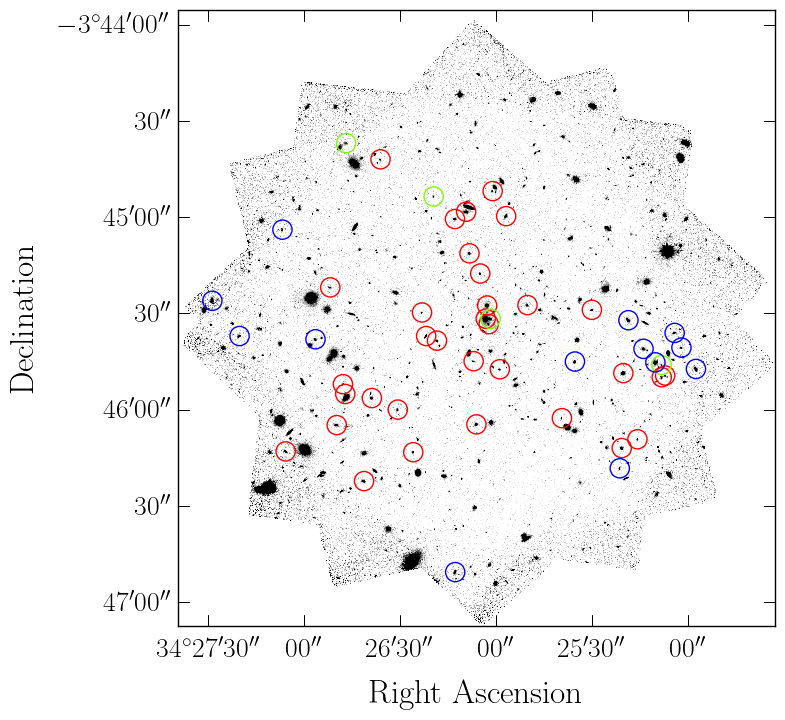

In [11]:
# the next task is then to add circles around each member galaxy:

# first we start with the image from above:

ax1=plt.subplot(projection=xlssc_wcs)
ax1.imshow(xlssc_hdu.data,vmin=0.0040,vmax=0.05,cmap='gray_r', interpolation='none')
# restricts image to just range of interest:
ax1.set_xlim(600,3700)
ax1.set_ylim(3800,600)
ax1.grid(False)
ax1.invert_yaxis()

# converts the x-axis to degrees and works with the ticks:
lon = ax1.coords[0]
lat = ax1.coords[1]
lon.set_axislabel('Right Ascension')
lat.set_axislabel('Declination')
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(number=6)
lat.set_ticks(number=7)

# increases figure size:
ff = plt.gcf()
ff.set_size_inches(12,8)

# converts into pixel coordinates:

# first gold:

pix_coords_gold = [[] for i in range(len(gold_RA))]
for i in range(len(gold_RA)):
    coord = SkyCoord(gold_RA[i],gold_DEC[i],unit=u.deg)
    pixels = xlssc_wcs.world_to_pixel(coord)
    pix_coords_gold[i] = pixels
    
mem_pix_gold = np.array(pix_coords_gold).T   

# adds circles:
for i in range(len(mem_pix_gold[1])):
    if math.isnan(mem_pix_gold[0][i])==False:
        centre = (mem_pix_gold[0][i],mem_pix_gold[1][i])
        circ = plt.Circle( centre,50,fill = False,color='r')
        ax1.add_patch(circ)
    else:
        pass

# then silver:

pix_coords_sil = [[] for i in range(len(silver_RA))]
for i in range(len(silver_RA)):
    coord = SkyCoord(silver_RA[i],silver_DEC[i],unit=u.deg)
    pixels = xlssc_wcs.world_to_pixel(coord)
    pix_coords_sil[i] = pixels
    
mem_pix_sil = np.array(pix_coords_sil).T   

# adds circles:
for i in range(len(mem_pix_sil[1])):
    if math.isnan(mem_pix_sil[0][i])==False:
        centre = (mem_pix_sil[0][i],mem_pix_sil[1][i])
        circ = plt.Circle( centre,50,fill = False,color='lawngreen')
        ax1.add_patch(circ)
    else:
        pass
    
# and for foreground:

pix_coords_fg = [[] for i in range(len(fg_RA))]
for i in range(len(fg_RA)):
    coord = SkyCoord(fg_RA[i],fg_DEC[i],unit=u.deg)
    pixels = xlssc_wcs.world_to_pixel(coord)
    pix_coords_fg[i] = pixels
    
mem_pix_fg = np.array(pix_coords_fg).T

for i in range(len(mem_pix_fg[1])):
    if math.isnan(mem_pix_fg[0][i])==False:
        centre = (mem_pix_fg[0][i],mem_pix_fg[1][i])
        circ = plt.Circle( centre,50,fill = False,color='b')
        ax1.add_patch(circ)
    else:
        pass
#ax1.invert_yaxis()

plt.show()

In [12]:
reds = cat_lo.T[12]

In [13]:
reds_rest = [reds[i] for i in range(len(reds))if (1.9<reds[i]<2.1) ]
len(reds_rest)

list_of_reds = [1.90, 1.90, 1.905,2.0051, 2.004, 2.004, 2.024]

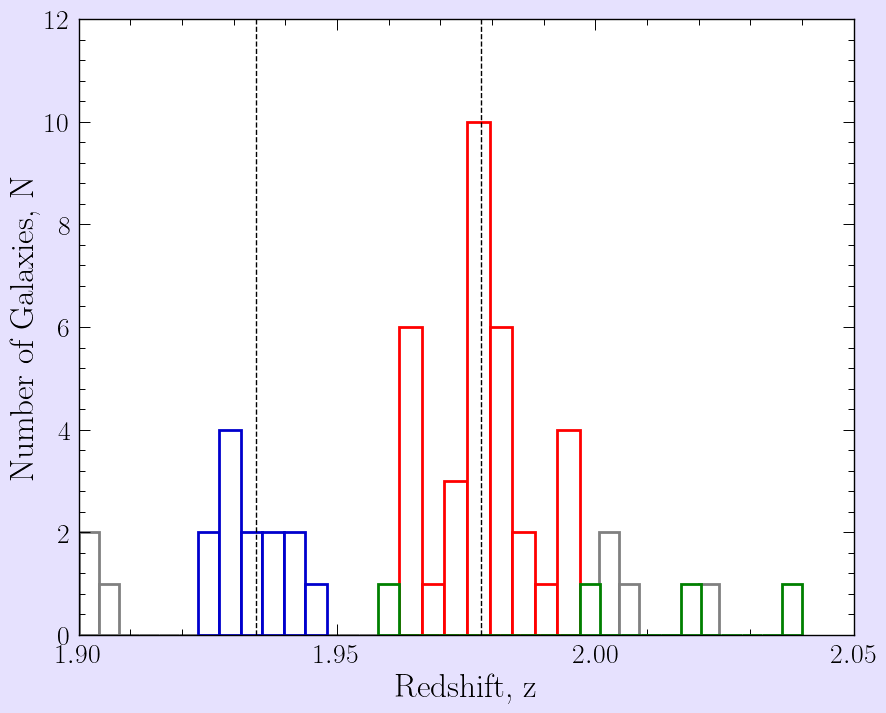

In [54]:
# we now want to make a histogram of the galaxies in the member 
# groups for their respective redshifts:




width=10
height=8
ff, (ax1) = plt.subplots(1,1,sharey=True,sharex=True)
ff.set_figwidth(width)
ff.set_figheight(height)

shift = 0.001
ax1.hist(mem_z*gold_mask, bins=8, fill=True,color='w',linewidth=2,edgecolor='r')
ax1.hist(mem_z*silver_mask-shift, bins=21, fill=True,color='w',linewidth=2,edgecolor='g')
ax1.hist(mem_z*fg_mask, bins=6, fill=True,color='w',linewidth=2,edgecolor='mediumblue')

ax1.hist(list_of_reds, bins=32, fill=True, color='w', linewidth=2, edgecolor='gray',zorder=0)




ax1.axvline(x=np.nanmean(mem_z*gold_mask), c='k', linewidth=1,linestyle= '--')
ax1.axvline(x=np.nanmean(mem_z*fg_mask), c='k', linewidth=1,linestyle= '--')


# restricts image to just range of interest:
ax1.set_xlim(1.90,2.05)
ax1.set_ylim(0,12)

#ax1.set_title("Histogram of Various Member Groups' Redshift")
ax1.set_xlabel(r"Redshift, z", fontsize=24)
ax1.set_ylabel("Number of Galaxies, N",fontsize=24)

ax1.xaxis.set_minor_locator(MultipleLocator(0.01))
ax1.xaxis.set_major_locator(MultipleLocator(0.05))

ax1.yaxis.set_minor_locator(MultipleLocator(0.4))
ax1.yaxis.set_major_locator(MultipleLocator(2))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")


ax1.xaxis.set_ticks_position('both') # THIS IS THE ONLY CHANGE
ax1.yaxis.set_ticks_position('both')

ax1.grid(False)

ff.set_facecolor('#e6e1fe')

plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/499_redshifts_intro", dpi=250)


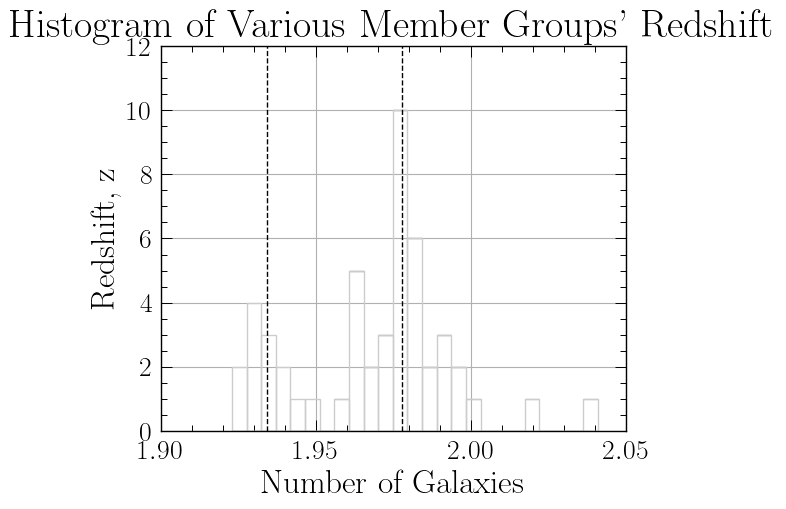

In [15]:
import pandas as pd


new_notes = ['G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G',
       'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G',
       'G', 'G', 'G', 'G', 'G', 'G', 'G', 'S', 'S', 'S', 'S', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F']

G_z = mem_z*gold_mask
S_z = mem_z*silver_mask
F_z = mem_z*fg_mask

sorted_zs = [np.array(G_z),np.array(S_z),np.array(F_z)]

width=6
height=5
ff, (ax1) = plt.subplots(1,1, sharex=True, sharey=True)
ff.set_figwidth(width)
ff.set_figheight(height)

ax1.set_xlim(1.90,2.05)
ax1.set_ylim(0,12)

ax1.set_title("Histogram of Various Member Groups' Redshift")
ax1.set_ylabel(r"Redshift, z")
ax1.set_xlabel("Number of Galaxies")

z_mask_frame = pd.DataFrame({'note': list(new_notes),
                             'z' : mem_z})

df_mask=z_mask_frame.pivot(columns='note',values='z')


ax1.axvline(x=np.nanmean(mem_z*gold_mask), c='k', linewidth=1,linestyle= '--')
ax1.axvline(x=np.nanmean(mem_z*fg_mask), c='k', linewidth=1,linestyle= '--')
ax1.xaxis.set_minor_locator(MultipleLocator(0.01))
ax1.xaxis.set_major_locator(MultipleLocator(0.05))

ax1.yaxis.set_minor_locator(MultipleLocator(0.5))
ax1.yaxis.set_major_locator(MultipleLocator(2))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in", color="black")
ax1.tick_params(which="minor", axis="y", direction="in",color="black")


ax1.xaxis.set_ticks_position('both') # THIS IS THE ONLY CHANGE
ax1.yaxis.set_ticks_position('both')

ax1.hist(sorted_zs,bins=25, color=['r','g','b'],fill=False,linewidth=1,histtype='bar', stacked=True)#, edgecolor=[0.4,0.2,0.6,0.4])
plt.show()

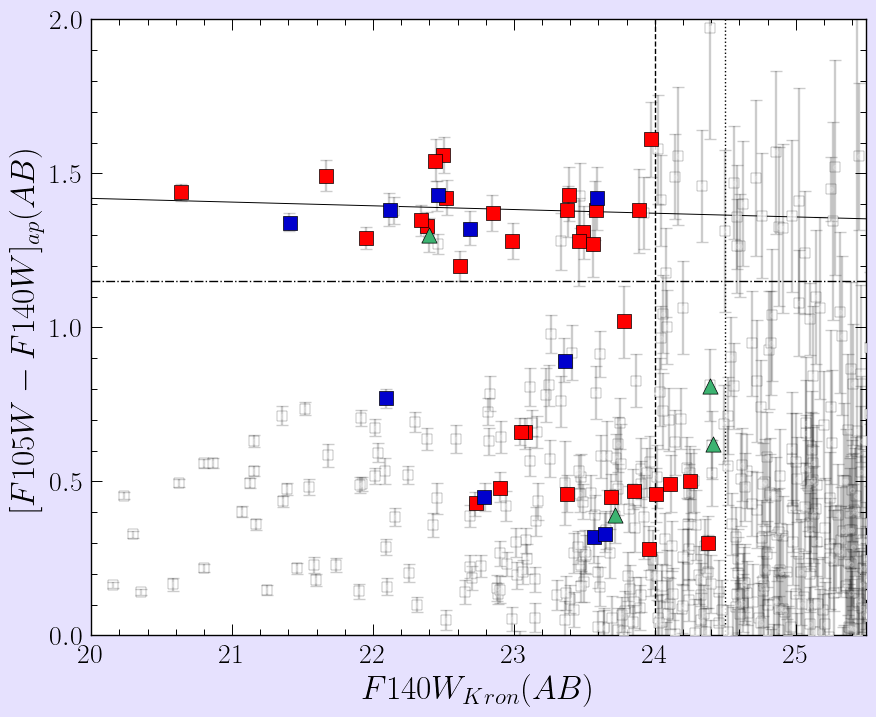

In [53]:
# for the next task, we need to find the color of all bodies in the sample.
# then split this into members and non-members.

# the color and magnitude of the members are here, with masks:

gold_c = mem_col*gold_mask; silver_c = mem_col*silver_mask
fg_c = mem_col*fg_mask; gold_mag = mem_mag*gold_mask;
silver_mag = mem_mag*silver_mask; fg_mag = mem_mag*fg_mask

# we can now plot these against one another:

width=10
height=8
ff, (ax1) = plt.subplots(1,1, sharex=True, sharey=True)
ff.set_figwidth(width)
ff.set_figheight(height)

ax1.set_xlim(20,25.5)
ax1.set_ylim(0,2)

#ax1.set_title("Colour-Magnitude Diagram of all Galaxies Within the HST Field")
ax1.set_ylabel(r"$[F105W-F140W]_{ap}(AB)$",fontsize=24)
ax1.set_xlabel(r"$F140W_{Kron}(AB)$",fontsize=24)



#ax1.axvline(x=np.nanmean(mem_z*gold_mask), c='k', linewidth=1,linestyle= '--')
ax1.xaxis.set_minor_locator(MultipleLocator(0.2))
ax1.xaxis.set_major_locator(MultipleLocator(1))

ax1.yaxis.set_minor_locator(MultipleLocator(0.1))
ax1.yaxis.set_major_locator(MultipleLocator(0.5))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') # THIS IS THE ONLY CHANGE
ax1.yaxis.set_ticks_position('both')

ax1.scatter(gold_mag, gold_c, s=100,marker='s', color='r', edgecolor='k', linewidth=0.5,zorder=20)
ax1.scatter(silver_mag, silver_c,s=120, marker='^',color='mediumseagreen', edgecolor='k', linewidth=0.5,zorder=20)
ax1.scatter(fg_mag, fg_c,s=100, marker='s', color='mediumblue', edgecolor='k', linewidth=0.5,zorder=20)

F140W = np.array(cat_short[9])
F105W = np.array(cat_short[5])
F140WP = np.array(cat_short[7])

ax1.scatter(F140WP, (F105W-F140W), color='w', s=50,edgecolor='k', linewidth=0.2, alpha=0.8,zorder=5,marker='s')

ax1.errorbar(F140WP, (F105W-F140W), yerr=col_unc,c='w',fmt='.',alpha=0.2, zorder=10,ecolor='black',capsize=4)

ax1.axvline(24, c='k', linewidth=1,linestyle= '--')
ax1.axvline(24.5, c='k', linewidth=1,linestyle= ':')

ax1.axhline(1.15, c='k', linewidth=1,linestyle= '-.')


col_mask = np.array([0.0 for i in range(len(mem_ID))])

for i in range(len(mem_col)):
    col = mem_col[i]
    
    if (col > 1.15):
        col_mask[i] = 1
        
    else:
        pass

red_seq_col = mem_col*col_mask*gold_mask
for i in range(len(red_seq_col)):
    if math.isnan(red_seq_col[i])==True:
        red_seq_col[i]=0.0
        
red_seq_mag = mem_mag*col_mask*gold_mask
for i in range(len(red_seq_mag)):
    if math.isnan(red_seq_mag[i])==True:
        red_seq_mag[i]=0.0

red_seq_mag=red_seq_mag[red_seq_mag != 0]
red_seq_col=red_seq_col[red_seq_col != 0]

        
m,b = np.polyfit(red_seq_mag, red_seq_col,1)
xx = np.linspace(20,26,100)

ax1.plot(xx,m*xx+b,color='k',linewidth=0.7)


# TODO: figure out why the fit is so much different/the 
#criterion of red-sequence

# emis_col = mem_col * e_mask; emis_mag = mem_mag * e_mask
# emis_coord = np.array([emis_mag,emis_col])

# for i in range(len(emis_coord[1])):
    
#     if math.isnan(emis_coord[1][i])==False:
#         centre = (emis_coord[0][i],emis_coord[1][i])
#         circ = Ellipse(centre,0.39,0.13,fill = False,color='k')
#         ax1.add_patch(circ)
#     else:
#         pass

#ax1.axis("equal")
ax1.grid(False)
ff.set_facecolor('#e6e1fe')

plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/499_color_mag_intro", dpi=250)



In [17]:
F140W

array([24.9637, 19.3027, 25.3051, ..., 26.9337, 26.1066, 25.7783])

In [18]:
# we want to add R_500 to the first plot. We know 
# the radius in Kpc. need the distance to the cluster:
# using calculator https://www.astro.ucla.edu/~wright/CosmoCalc.html

d_lum = 14236.6 * u.Mpc

D_rad = 295 * u.kpc

theta_rad = 206265 * D_rad.to(u.Mpc)/d_lum

In [19]:
cat_sh.T[5]-cat_sh.T[9]

array([74.0363,  3.85  , 73.6949, ..., -0.1243,  0.3504,  0.7275])

In [20]:
arcmin_to_kpc = 8.530 # kpc/"
degree_to_kpc = arcmin_to_kpc * 3600 # kpc/degree


kpc_to_degree = 1/degree_to_kpc

r500= 295 * kpc_to_degree
r200 = 443 * kpc_to_degree

In [21]:

r200, r500

(0.014426208154226912, 0.009606617168164648)

In [22]:
len(xlssc_hdu.data)

4312

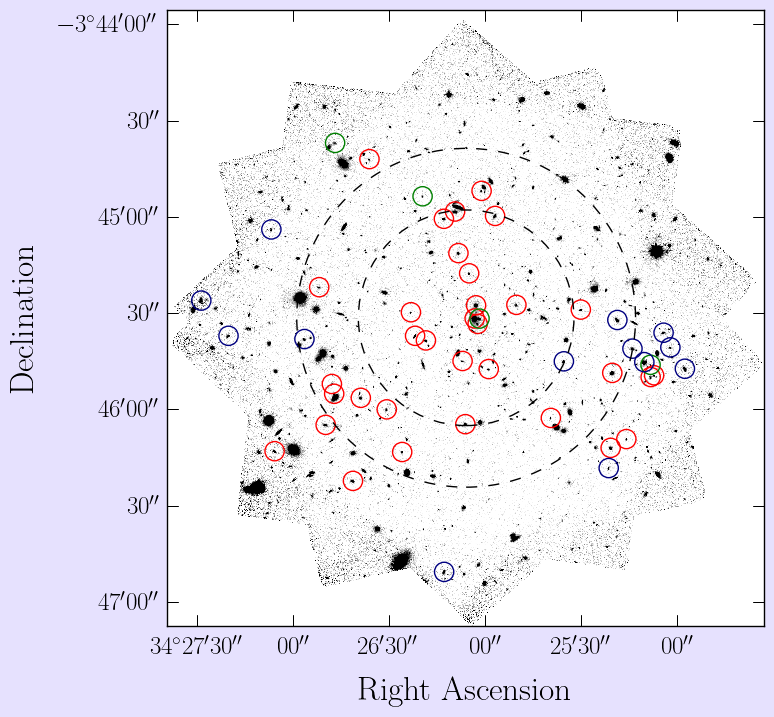

In [52]:
ax1=plt.subplot(projection=xlssc_wcs)
ax1.imshow(xlssc_hdu.data,vmin=0.0040,vmax=0.05,cmap='gray_r', interpolation='none')
# restricts image to just range of interest:
ax1.set_xlim(600,3700)
ax1.set_ylim(3800,600)
ax1.invert_yaxis()

# converts the x-axis to degrees and works with the ticks:
lon = ax1.coords[0]
lat = ax1.coords[1]
lon.set_axislabel('Right Ascension', fontsize=24)
lat.set_axislabel('Declination', fontsize=24)
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(number=6)
lat.set_ticks(number=7)

ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=18)
# increases figure size:
ff = plt.gcf()
ff.set_size_inches(10,8)

# converts into pixel coordinates:

# first gold:

pix_coords_gold = [[] for i in range(len(gold_RA))]
for i in range(len(gold_RA)):
    coord = SkyCoord(gold_RA[i],gold_DEC[i],unit=u.deg)
    pixels = xlssc_wcs.world_to_pixel(coord)
    pix_coords_gold[i] = pixels
    
mem_pix_gold = np.array(pix_coords_gold).T   

# adds circles:
for i in range(len(mem_pix_gold[1])):
    if math.isnan(mem_pix_gold[0][i])==False:
        centre = (mem_pix_gold[0][i],mem_pix_gold[1][i])
        circ = plt.Circle( centre,50,fill = False,color='red')
        ax1.add_patch(circ)
    else:
        pass

# then silver:

pix_coords_sil = [[] for i in range(len(silver_RA))]
for i in range(len(silver_RA)):
    coord = SkyCoord(silver_RA[i],silver_DEC[i],unit=u.deg)
    pixels = xlssc_wcs.world_to_pixel(coord)
    pix_coords_sil[i] = pixels
    
mem_pix_sil = np.array(pix_coords_sil).T   

# adds circles:
for i in range(len(mem_pix_sil[1])):
    if math.isnan(mem_pix_sil[0][i])==False:
        centre = (mem_pix_sil[0][i],mem_pix_sil[1][i])
        circ = plt.Circle( centre,50,fill = False,color='g')
        ax1.add_patch(circ)
    else:
        pass
    
# and for foreground:

pix_coords_fg = [[] for i in range(len(fg_RA))]
for i in range(len(fg_RA)):
    coord = SkyCoord(fg_RA[i],fg_DEC[i],unit=u.deg)
    pixels = xlssc_wcs.world_to_pixel(coord)
    pix_coords_fg[i] = pixels
    
mem_pix_fg = np.array(pix_coords_fg).T

for i in range(len(mem_pix_fg[1])):
    if math.isnan(mem_pix_fg[0][i])==False:
        centre = (mem_pix_fg[0][i],mem_pix_fg[1][i])
        circ = plt.Circle( centre,50,fill = False,color='navy')
        ax1.add_patch(circ)
    else:
        pass

# adds a circle at the centre:

centre = SkyCoord(RA_TARG,DEC_TARG,unit=u.deg)
pix_centre = xlssc_wcs.world_to_pixel(centre)



pix_centre = (pix_centre[0]-50, pix_centre[1])
circ_200 = plt.Circle(pix_centre,880,fill = False,color='k', linestyle=(0,(8,8)), label=r'$r_{500}$')
ax1.add_patch(circ_200)    
circ_500 = plt.Circle(pix_centre,560,fill = False,color='k', linestyle=(0,(8,8)), label=r'$r_{500}$')
ax1.add_patch(circ_500) 
ax1.grid(False)
    
ff.set_facecolor('#e6e1fe')
#ff.tight_layout(pad=-3.0)

plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/499_members_intro", dpi=250)

In [25]:
296*2

592

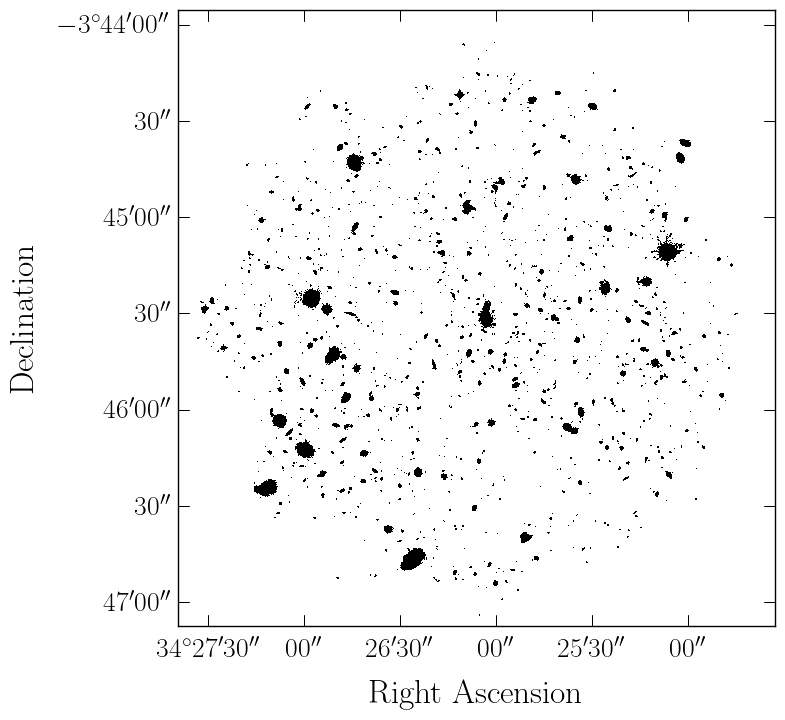

In [32]:
# we now want to load in and use the object extracted fits image:

# will try the world coordinate system built into astropy:

extract_hdu = fits.open(extract_path)[0]
extract_wcs = WCS(extract_hdu.header)

ax1=plt.subplot(projection=extract_wcs)
ax1.imshow(extract_hdu.data,vmin=0.0040,vmax=0.05,cmap='gray_r', interpolation='none')
# restricts image to just range of interest:
ax1.set_xlim(600,3700)
ax1.set_ylim(3800,600)

#ax1.set_title("XLSSC122 Image")
ax1.grid(False)
ax1.invert_yaxis()

# converts the x-axis to degrees and works with the ticks:
lon = ax1.coords[0]
lat = ax1.coords[1]
lon.set_axislabel('Right Ascension')
lat.set_axislabel('Declination')
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(number=6)
lat.set_ticks(number=7)

# increases figure size:
ff = plt.gcf()
ff.set_size_inches(10,8)

# TODO:
# figure out why ticks are not coming up here

plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/segmap_intro", dpi=250)

In [27]:
# first attempt at a masking program

def Nth_object(x,N):
    '''
    takes a number x and 
    an integer N corresponding to
    an object and returns if it is 
    a desired pixel
    '''
    if x == N:
        x = 1
    elif x != N:
        x = 0 
    return x
    
Nth_obj = np.vectorize(Nth_object)


def extract_mask(N, file):
    '''
    Takes an integer N and 
    creates a mask for the specified
    object
    '''
    
    mask = Nth_obj(file, N)
    return mask
    
    
# this does item by item... TO SLOW. Need to do it to the entire image in one go
# ... maybe by using a list of specified items


In [28]:
# do not run this!!!!!

# creates list of masks for each item in the id'ed members

#masks = [extract_mask(mem_ID[i],extract_hdu.data) for i in range(len(mem_ID))]



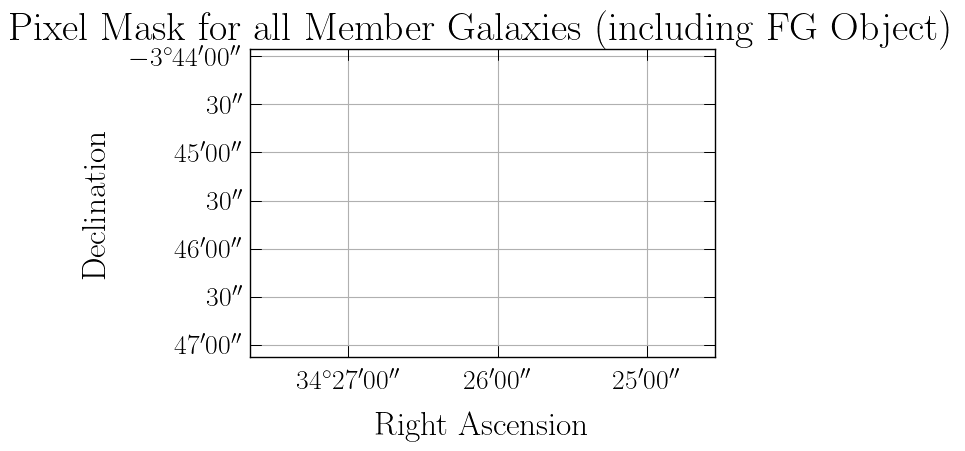

In [29]:
# plots the member_mask

ax1=plt.subplot(projection=extract_wcs)

#ax1.imshow(member_mask,vmin=0.0040,vmax=0.05,cmap='gray_r', interpolation='none')

    
# restricts image to just range of interest:
ax1.set_xlim(600,3700)
ax1.set_ylim(3800,600)

#ax1.set_title("XLSSC122 Image")
ax1.grid(False)
ax1.invert_yaxis()
ax1.set_title("Pixel Mask for all Member Galaxies (including FG Object)")
# converts the x-axis to degrees and works with the ticks:
lon = ax1.coords[0]
lat = ax1.coords[1]
lon.set_axislabel('Right Ascension')
lat.set_axislabel('Declination')
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(number=4)
lat.set_ticks(number=8)
ax1.grid(False)

# increases figure size:
ff = plt.gcf()
ff.set_size_inches(6,4)

# TODO:
# figure out why ticks are not coming up here

plt.show()

In [30]:
# now that we can create a mask for an individual object, lets make one for
# a list of objects:


def single_mask(N,data=extract_hdu):
    '''
    Takes an object ID N and
    returns a mask for that
    particular object
    '''
    mask = data.data
    mask[mask!=N] = 0
    mask[mask==N]= 2
    mask[mask==0]= 1
    mask[mask==2]= 0
    return mask

def vector_mask(list_masks,data=extract_hdu):
    '''
    tasks list of objects and makes a single 
    mask out of them. Returns mask sum
    '''
    sum_mask = data.data
    for i in list_masks:
        sum_mask[sum_mask==i] = 2

    sum_mask[sum_mask!=2]= 0
    sum_mask[sum_mask==0]= 1
    sum_mask[sum_mask==2]= 0
    
    return sum_mask

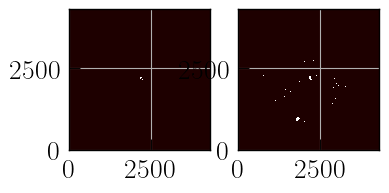

In [31]:
# now we need to test our mask function:
extract_hdu = fits.open(extract_path)[0]

mask_526 = single_mask(526,extract_hdu)

# and our vector mask function:

member_mask = vector_mask(mem_ID)

# plot:

ff,ax=plt.subplots(1,2)
ax[0].imshow(mask_526,vmin=0,vmax=1,cmap='pink_r', interpolation='none')
ax[1].imshow(member_mask,vmin=0,vmax=1,cmap='pink_r', interpolation='none')

ax[0].invert_yaxis()
ax[1].invert_yaxis()


ff = plt.gcf()
ff.set_size_inches(4,3)





In [151]:
# now lets test our function for many mask:

In [152]:
# 
extract_hdu = fits.open(extract_path)[0]

all_mem_ID = cat_lo.T[0]

ex_hdu_nomem = extract_hdu.data

# remove the members:

for i in mem_ID:
    ex_hdu_nomem[ex_hdu_nomem==i] = 0
# invert the matrix elements 1 -> 0, 0->1:

ex_hdu_nomem[ex_hdu_nomem!=0]= 2
ex_hdu_nomem[ex_hdu_nomem==0]= 1
ex_hdu_nomem[ex_hdu_nomem==2]= 0



In [93]:
np.shape(ex_hdu_nomem)

(4312, 4313)

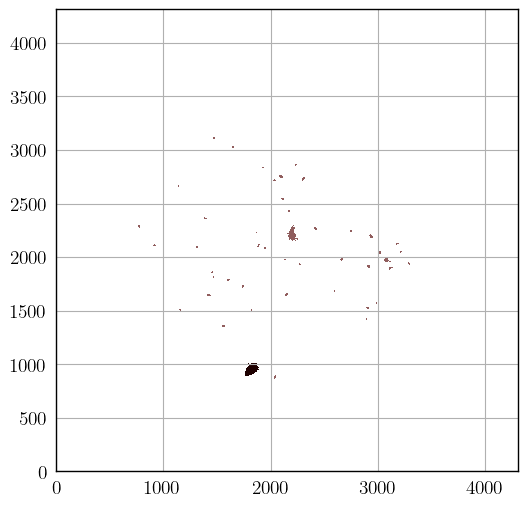

In [94]:
ff,ax=plt.subplots(1,1)
contrast = np.add(ex_hdu_nomem, 10*member_mask)
ax.imshow(contrast,vmin=0,vmax=5,cmap='pink', interpolation='none')
ax.invert_yaxis()
ff = plt.gcf()
ff.set_size_inches(10,6)

In [95]:
xlssc_remove = xlssc_hdu.data

xlssc_rem_plot = np.multiply(xlssc_remove, ex_hdu_nomem)

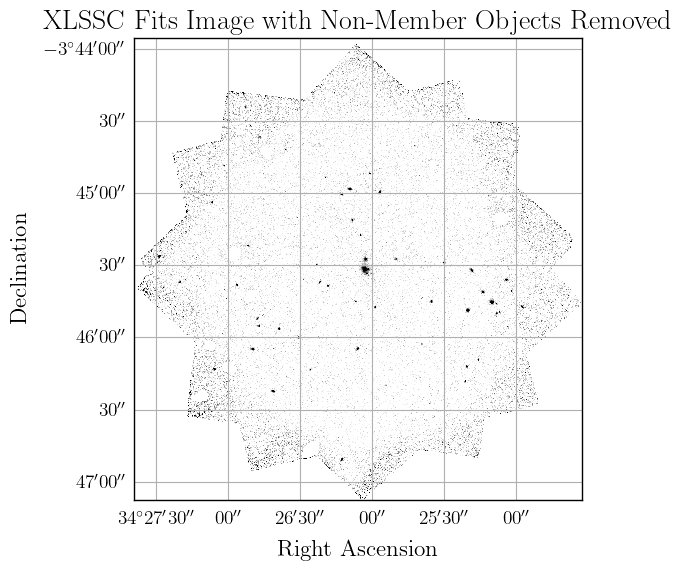

In [96]:


ax1=plt.subplot(projection=xlssc_wcs)
ax1.imshow(xlssc_rem_plot,vmin=0.0040,vmax=0.05,cmap='gray_r', interpolation='none')
# restricts image to just range of interest:
ax1.set_xlim(600,3700)
ax1.set_ylim(3800,600)
ax1.grid(False)
ax1.invert_yaxis()

# converts the x-axis to degrees and works with the ticks:
lon = ax1.coords[0]
lat = ax1.coords[1]
lon.set_axislabel('Right Ascension')
lat.set_axislabel('Declination')
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(number=6)
lat.set_ticks(number=7)

# increases figure size:
ff = plt.gcf()
ff.set_size_inches(8,6)

ax1.set_title("XLSSC Fits Image with Non-Member Objects Removed")

ax1.grid(False)
#ax1.invert_yaxis()
    
plt.show()

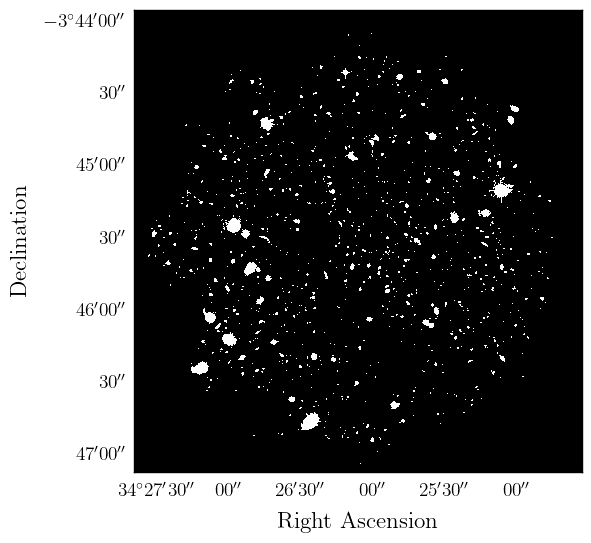

In [97]:
ax1=plt.subplot(projection=xlssc_wcs)
ax1.imshow(ex_hdu_nomem,vmin=0.004, vmax =0.05,cmap='gray_r', interpolation='none')
# restricts image to just range of interest:
ax1.set_xlim(600,3700)
ax1.set_ylim(3800,600)
ax1.grid(False)
ax1.invert_yaxis()

# converts the x-axis to degrees and works with the ticks:
lon = ax1.coords[0]
lat = ax1.coords[1]
lon.set_axislabel('Right Ascension')
lat.set_axislabel('Declination')
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(number=6)
lat.set_ticks(number=7)

# increases figure size:
ff = plt.gcf()
ff.set_size_inches(8,6)




#ax1.invert_yaxis()
    
plt.show()

In [98]:
# correlation functions:

import scipy.signal
import cv2

# three images:

member_image = xlssc_rem_plot
whole_image = xlssc_hdu.data
extract_image = extract_hdu.data

mem_whole_corr = scipy.signal.fftconvolve(member_image,whole_image[::-1, ::-1], mode='full')

#, mode='full')#, boundary='fill')

In [99]:
import cv2 

In [100]:
mem_whole_corr2 = cv2.filter2D(member_image, ddepth=-1, kernel=whole_image)
 
coeff_m_w_flat = np.corrcoef(member_image.flat, whole_image.flat)
coeff_e_w_flat = np.corrcoef(extract_image.flat, whole_image.flat)
coeff_m_e_flat = np.corrcoef(member_image.flat, extract_image.flat)

#coeff_m_w = scp.signal.correlate2d(member_image, whole_image)
#coeff_e_w = scp.signal.correlate2d(extract_image, whole_image)
#coeff_m_e = scp.signal.correlate2d(member_image, extract_image)


rs = [coeff_m_w_flat[0,1],coeff_e_w_flat[0,1],coeff_m_e_flat[0,1]]

In [101]:
rs

[0.020483929126304496, -0.04405264269111962, -0.0004058897261235129]

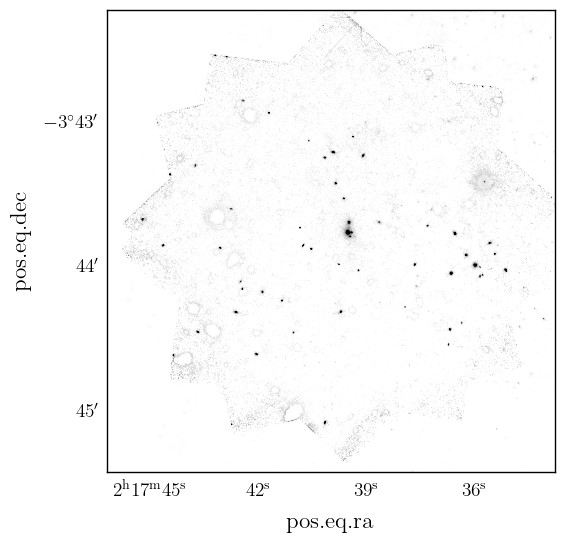

In [102]:


ax1=plt.subplot(projection=xlssc_wcs)
ax1.imshow(mem_whole_corr,vmin=0, vmax =600,cmap='gray_r', interpolation='none')
# restricts image to just range of interest:
ax1.set_xlim(1700,4800)
ax1.set_ylim(2300,5500)
ax1.grid(False)
#ax1.invert_yaxis()



# increases figure size:
ff = plt.gcf()
ff.set_size_inches(8,6)




#ax1.invert_yaxis()
    
plt.show()